# Rydberg circuits

In addition to the fermionic setting introduced in [the first tutorial](./01_introduction_and_fermionic_circuits.ipynb), the Qiskit cold atom module naturally supports Rydberg hardware, which is the neutral atom implementation of qubits. They are described through the Hamiltonian:

$$
\hat{H}_{ryd} = \Omega \sum_i \sigma_{x,i} + \Delta \sum_i \sigma_{z,i} + \phi \sum_{i\neq j} \frac{\hat{n}_i \hat{n}_j}{|i-j|^6}
$$

The occupation number is defined as $\hat{n}_i = Z_i + \frac{1}{2}$ and the spin operators are $\sigma_{x,i} = \frac{1}{2}X_i$ as well as $\sigma_{z,i} = \frac{1}{2}Z_i$. Here, the unit of information, i.e. the individual wires in the quantum circuit, are given as quantum angular momenta or spins of length $S = 1/2$. The following simulation is based on the `SpinSimulator()` backend which was introduced for the case of high-dimensional spins in [the tutorial 2](./02_spin_circuits.ipynb).

In this tutorial we will focus on the production of two central experiments of Rydberg atoms:

Typical applications are:

- [Messin et al.](https://www.nature.com/articles/nphys1183), which demonstrate dynamically a Rydberg blockade.
- [Bernien et al.](https://arxiv.org/abs/1707.04344), which demonstrates larger spin structures that arise dynamically.




## Rydberg blockade in a two atom system

In the first step, we will employ a `qiskit-cold-atoms` to implement the foundational experiments on Rydberg blockade. By [Messin et al.](https://www.nature.com/articles/nphys1183). In a first step, we will simulate the simple Rabi oscillation experiments that they used as reference.

In [1]:
from qiskit import QuantumRegister
from qiskit.circuit import QuantumCircuit, Parameter

from qiskit_cold_atom.spins.spins_gate_library import RydbergFull
from qiskit_cold_atom.spins import SpinSimulator

import numpy as np
import matplotlib.pyplot as plt

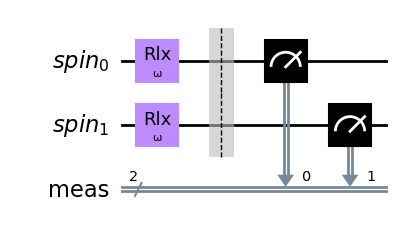

In [2]:
Nwires = 2
backend = SpinSimulator()
qc_rabi = QuantumCircuit(QuantumRegister(Nwires, "spin"))

all_modes=range(Nwires)
omega_t = Parameter("ω")

qc_rabi.rlx( omega_t, [0, 1])

qc_rabi.measure_all()
qc_rabi.draw(output='mpl')

In [3]:
phases = np.linspace(0, 2*np.pi,15)

rabi_list = [
    qc_rabi.assign_parameters(
        {omega_t: phase},
        inplace=False,
    )
    for phase in phases
]

job_rabi = backend.run(rabi_list, shots=500)
result_rabi = job_rabi.result()
counts_rabi = result_rabi.get_counts()

next we have to count the same of the two spins that are `1` at the same time

In [4]:
outcomes_rabi = [result_rabi.get_memory(i) for i in range(len(rabi_list))]
for i, outcome in enumerate(outcomes_rabi):
    for j, run in enumerate(outcome):
        outcomes_rabi[i][j] = np.array(run.split(' '), dtype = int)
outcomes_rabi = np.array(outcomes_rabi)

In [5]:
means_rabi = outcomes_rabi.mean(axis=1)
sum_rabi = means_rabi.sum(axis=1)

Text(0, 0.5, 'sum of spins up')

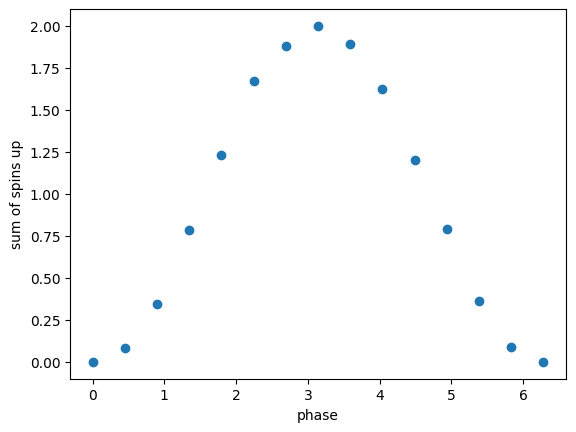

In [6]:
f, ax = plt.subplots()

ax.plot(phases, sum_rabi, 'o')
ax.set_xlabel('phase')
ax.set_ylabel('sum of spins up')

### Including the Blockade

Next, we implement the protocol, which shows Rydberg blockade. This is done with the `rydberg_full` gate. It implements the already mentionned Hamiltonian time dynamics.

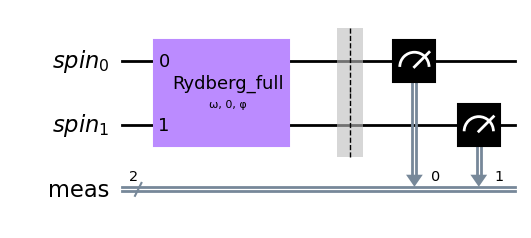

In [7]:
Nwires = 2
backend = SpinSimulator()
qc_block = QuantumCircuit(QuantumRegister(Nwires, "spin"))

all_modes=range(Nwires)
omega_t = Parameter("ω")
phi_t = Parameter("φ")

qc_block.rydberg_full(omega = omega_t, delta =0, phi = phi_t, modes=all_modes)

qc_block.measure_all()
qc_block.draw(output='mpl')

In [8]:
phases = np.linspace(0, 2*np.pi,15)

block_list = [
    qc_block.assign_parameters(
        {omega_t: phase, phi_t: phase*10},
        inplace=False,
    )
    for phase in phases
]

job_block = backend.run(block_list, shots=500)
result_block = job_block.result()

In [9]:
outcomes = [result_block.get_memory(i) for i in range(len(block_list))]
for i, outcome in enumerate(outcomes):
    for j, run in enumerate(outcome):
        outcomes[i][j] = np.array(run.split(' '), dtype = int)
outcomes = np.array(outcomes)

means_block = outcomes.mean(axis=1)
sum_block = means_block.sum(axis=1)

now we can compare the dynamics without Rydberg blockade and with Rydberg blockade

Text(0, 0.5, 'sum of spins up')

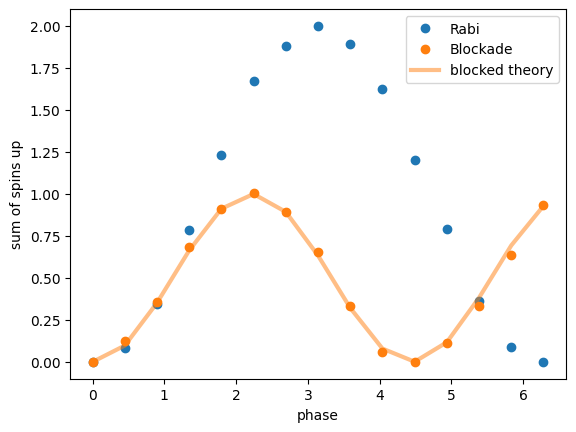

In [10]:
f, ax = plt.subplots()

ax.plot(phases, sum_rabi, 'o', label= 'Rabi')
ax.plot(phases, sum_block, 'o', label= 'Blockade')
ax.plot(phases, (1-np.cos(np.sqrt(2)*phases))/2, '-', color = "C1", alpha = 0.5, linewidth = 3, label= 'blocked theory')
ax.legend()
ax.set_xlabel('phase')
ax.set_ylabel('sum of spins up')

We can see observe two things:

- The blockade almost completely suppressed the existence of both spins being up at the same time. This is due to its energetic cost.
- The oscillation frequency is increased by a factor of $\sqrt(2)$. This is an indication of the coherent, entangled dynamics, which are discussed in detail in the original paper.

### Controlled entanglement

Let us now also visualized in a single circuit how the rydberg Blockade might be used to generate an entangled state. For this we will employ the gate `rydberg_block`, which generates the blockade.

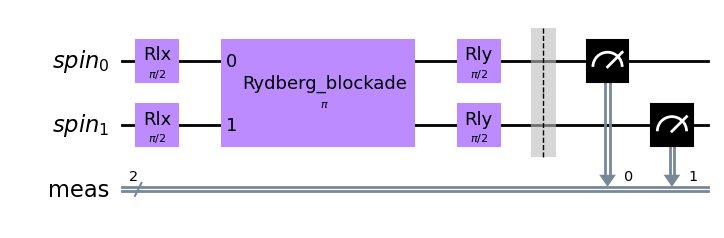

In [37]:
Nwires = 2
backend = SpinSimulator()
qc_entangle = QuantumCircuit(QuantumRegister(Nwires, "spin"))

all_modes=range(Nwires)

qc_entangle.rlx(np.pi/2, all_modes)
qc_entangle.rydberg_block(np.pi, modes=all_modes)
qc_entangle.rly(np.pi/2, 0)
qc_entangle.rly(np.pi/2, 1)
qc_entangle.measure_all()
qc_entangle.draw(output='mpl')

In [38]:
job_entangle = backend.run(qc_entangle, shots=500)
result_entangle = job_entangle.result()
print(result_entangle.get_counts())

{'0 0': 266, '1 1': 234}


As we can see the resulting state is entangled, just as we envisionned.

## Spin structures from Rydberg interactions

In this section we will reproduce some parts of the results of the paper by [Bernien et al.](https://arxiv.org/abs/1707.04344), which demonstrates larger spin structures that arise dynamically. We will do this first based on the local spin simulator and then demonstrate how it works in a remote system.

Let us start out once more with the reference without Rydberg blockade

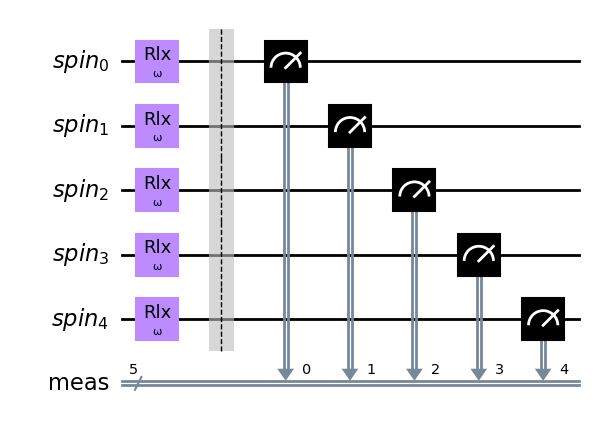

In [11]:
Nwires = 5
backend = SpinSimulator()
qc_rabi = QuantumCircuit(QuantumRegister(Nwires, "spin"))

all_modes=range(Nwires)
omega_t = Parameter("ω")

qc_rabi.rlx( omega_t, all_modes)

qc_rabi.measure_all()
qc_rabi.draw(output='mpl')

In [12]:
phases = np.linspace(0, 2*np.pi,15)

rabi_list = [
    qc_rabi.assign_parameters(
        {omega_t: phase},
        inplace=False,
    )
    for phase in phases
]

job_rabi = backend.run(rabi_list, shots=500)
result_rabi = job_rabi.result()

outcomes_rabi = [result_rabi.get_memory(i) for i in range(len(rabi_list))]
for i, outcome in enumerate(outcomes_rabi):
    for j, run in enumerate(outcome):
        outcomes_rabi[i][j] = np.array(run.split(' '), dtype = int)
outcomes_rabi = np.array(outcomes_rabi)

Text(0.5, 0, 'time')

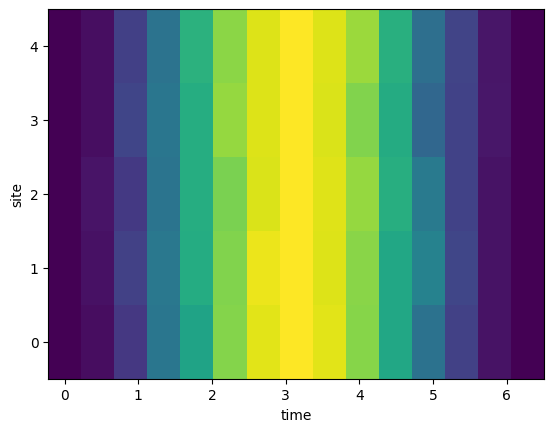

In [13]:
means_rabi = outcomes_rabi.mean(axis=1)

f, ax = plt.subplots()
ax.pcolormesh(phases,np.arange(Nwires), means_rabi.T)
ax.set_ylabel('site')
ax.set_xlabel('time')

We can see the all sites oscillate accordingly. So let us now implement the Blockade and observe its effect on the arising spin structures

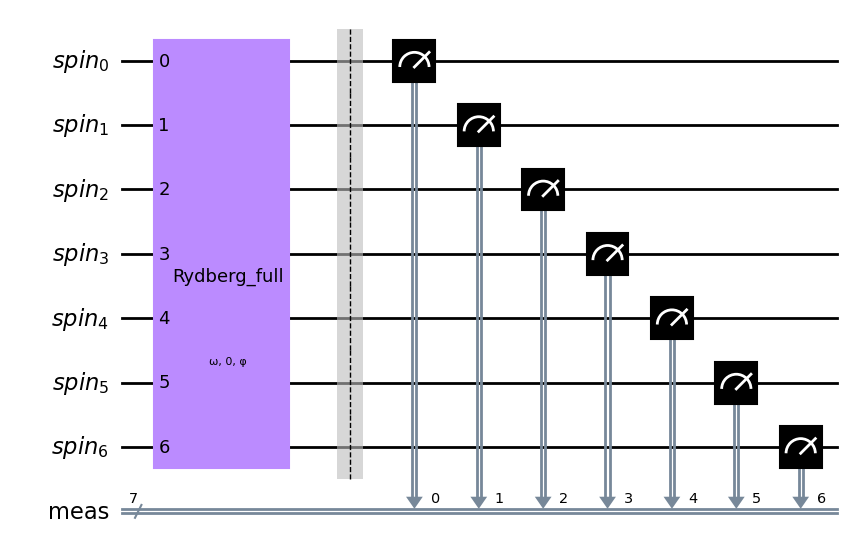

In [14]:
Nwires = 7
backend = SpinSimulator()
qc_block = QuantumCircuit(QuantumRegister(Nwires, "spin"))

all_modes=range(Nwires)
omega_t = Parameter("ω")
phi_t = Parameter("φ")

qc_block.rydberg_full(omega = omega_t, delta =0, phi = phi_t, modes=all_modes)

qc_block.measure_all()
qc_block.draw(output='mpl')

In [15]:
phases = np.linspace(0, 2*np.pi,15)

block_list = [
    qc_block.assign_parameters(
        {omega_t: phase, phi_t: phase*5},
        inplace=False,
    )
    for phase in phases
]

job_block = backend.run(block_list, shots=500)
result_block = job_block.result()

In [16]:
outcomes = [result_block.get_memory(i) for i in range(len(block_list))]
for i, outcome in enumerate(outcomes):
    for j, run in enumerate(outcome):
        outcomes[i][j] = np.array(run.split(' '), dtype = int)
outcomes = np.array(outcomes)

means_block = outcomes.mean(axis=1)

Text(0.5, 0, 'time')

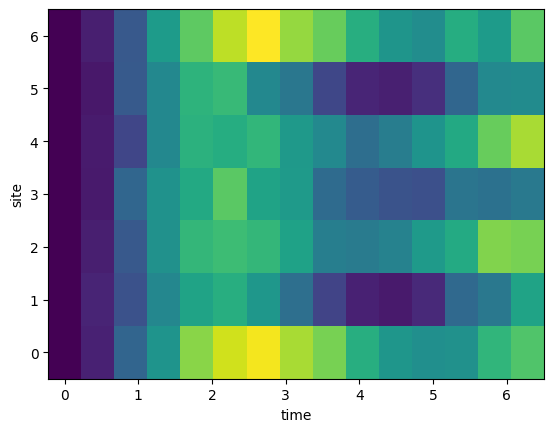

In [17]:
f, ax = plt.subplots()
ax.pcolormesh(phases,np.arange(Nwires), means_block.T)
ax.set_ylabel('site')
ax.set_xlabel('time')

As you can see the interactions now substantially altered the dynamics:

- On the outer sites that first oscillation appears quicker, which is reminiscent of the blockade scenario with two qubits.
- On the site 1 and 5 the dynamics is strongly suppressed due to the strong interaction with all the neighbors.
- An alternating spin structure appears dynamically.

## Optional: Working on a cloud simulator

We would also like to send such circuits to some real hardware and investigate these results. In this last section, we will present this possibility with the [alqor](https://qlued.alqor.io) provider. 

<div class="alert alert-block alert-info">
<b>Note:</b> To run the cells in this part of the tutorial that interface with a remote device backend, you'll need to have a registered account with a valid username and token for this provider. You can obtain such credentials by visiting the <a href ='https://qlued.alqor.io/accounts/login/'>sign-up page</a></div>

In [18]:
from qiskit_cold_atom.providers import ColdAtomProvider
from pprint import pprint

Saving/enabling your backend credentials (Optional if not alreayd done).

In [19]:
#provider = ColdAtomProvider.save_account(
#    url=[
#        "https://qlued.alqor.io/api/v2/singlequdit",
#        "https://qlued.alqor.io/api/v2/multiqudit",
#        "https://qlued.alqor.io/api/v2/fermions",
#        "https://qlued.alqor.io/api/v2/rydberg",
#    ],
#    username="name",
#    token="token",
#    overwrite=True
#)

We can now load the necessary backend

In [20]:
provider = ColdAtomProvider.load_account()

spin_device_backend = provider.get_backend("alqor_rydberg_simulator")
pprint(spin_device_backend.configuration().supported_instructions)

['rlx', 'rlz', 'rydberg_block', 'rydberg_full', 'barrier', 'measure']


As you can see from above the simulator backend does provide the necessary gate that we used previously. So we can now simply execute the circuits from above on the cloud hardware:

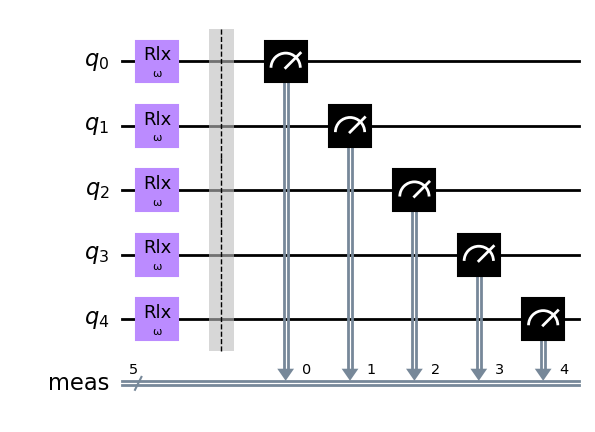

In [28]:
Nwires = 5

qc_rabi = QuantumCircuit(5)

all_modes=range(Nwires)
omega_t = Parameter("ω")

qc_rabi.rlx( omega_t, all_modes)

qc_rabi.measure_all()
qc_rabi.draw(output='mpl')

Now that we have created the circuit we can execute it in the same way as in the all the other tutorials.

In [30]:
phases = np.linspace(0, 2*np.pi,15)

remote_rabi_list = [
    qc_rabi.assign_parameters(
        {omega_t: phase},
        inplace=False,
    )
    for phase in phases
]

job_remote_rabi = spin_device_backend.run(remote_rabi_list, shots=500)

In [31]:
job_remote_rabi.job_id()

'20230421_034345-rydberg-fretchen-8d7ef'

In [32]:
job_rabi_retrieved = spin_device_backend.retrieve_job(job_id=job_remote_rabi.job_id())

print("job status: ", job_rabi_retrieved.status())

job status:  JobStatus.DONE


In [33]:
result_remote_rabi = job_rabi_retrieved.result()

In [34]:
outcomes = [result_remote_rabi.get_memory(i) for i in range(len(remote_rabi_list))]
for i, outcome in enumerate(outcomes):
    for j, run in enumerate(outcome):
        outcomes[i][j] = np.array(run.split(' '), dtype = int)
        
outcomes = np.array(outcomes)
means_remote_rabi = outcomes.mean(axis=1)

Text(0.5, 0, 'time')

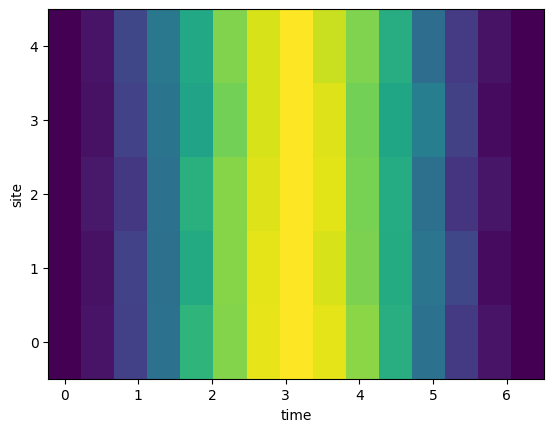

In [35]:
f, ax = plt.subplots()
ax.pcolormesh(phases,np.arange(5), means_remote_rabi.T)
ax.set_ylabel('site')
ax.set_xlabel('time')

### Blockade on a remote system

In this last step, we can execute the Ryber blockade on the remote system to observe the appearance of the alternating spin structure.

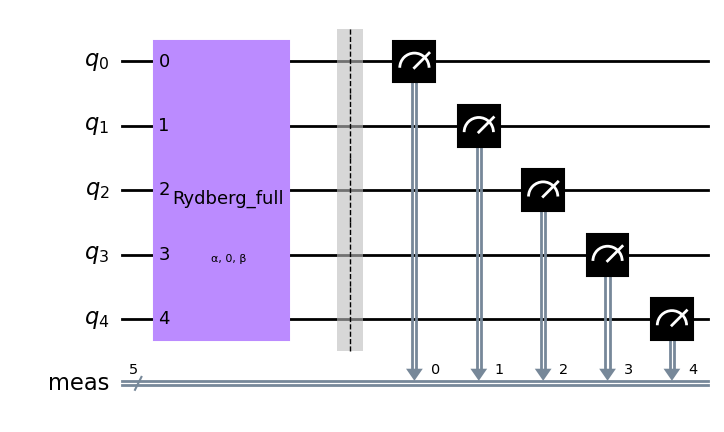

In [9]:
Nwires = 5
qc2 = QuantumCircuit(5)

all_modes=range(Nwires)
alpha = Parameter("α")
beta = Parameter("β")

qc2.rydberg_full(omega = alpha, delta =0, phi = beta, modes=all_modes)

qc2.measure_all()
qc2.draw(output='mpl')

In [13]:
phases = np.linspace(0, 2*np.pi,15)

circuit2_list = [
    qc2.assign_parameters(
        {alpha: phase, beta: phase*2},
        inplace=False,
    )
    for phase in phases
]

In [14]:
job2 = spin_device_backend.run(circuit2_list, shots=500)

In [15]:
job2.job_id()

'20230414_132821-rydberg-fretchen-222d6'

In [16]:
job_retrieved2 = spin_device_backend.retrieve_job(job_id=job2.job_id())

print("job status: ", job_retrieved2.status())

job status:  JobStatus.INITIALIZING


In [17]:
result2 = job_retrieved2.result()

make this a card of averages

In [18]:
outcomes = [result2.get_memory(i) for i in range(len(circuit2_list))]
for i, outcome in enumerate(outcomes):
    for j, run in enumerate(outcome):
        outcomes[i][j] = np.array(run.split(' '), dtype = int)
outcomes = np.array(outcomes)

In [19]:
means_1 = outcomes.mean(axis=1)
means_1.shape

(15, 5)

Text(0.5, 0, 'time')

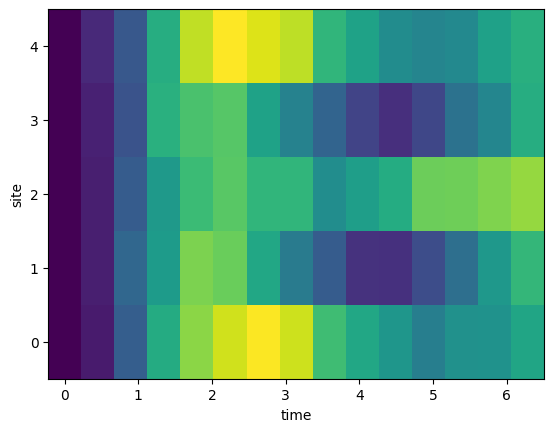

In [21]:
f, ax = plt.subplots()
ax.pcolormesh(phases,np.arange(5), means_1.T)
ax.set_ylabel('site')
ax.set_xlabel('time')